## Imports

In [19]:
%env LD_LIBRARY_PATH=/home/zach/anaconda3/envs/research/lib

env: LD_LIBRARY_PATH=/home/zach/anaconda3/envs/research/lib


In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import re
import codecs
from tqdm import tqdm

## Data Import and Cleaning

In [21]:
train = pd.read_csv('data/hateval2019_en_train.csv')
test = pd.read_csv('data/hateval2019_en_test.csv')
val = pd.read_csv('data/hateval2019_en_dev.csv')

train = train.drop(['TR','AG'],1)
test = test.drop(['TR','AG'],1)
val = val.drop(['TR','AG'],1)

/tmp/ipykernel_268586/675437588.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = train.drop(['TR','AG'],1)
/tmp/ipykernel_268586/675437588.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test = test.drop(['TR','AG'],1)
/tmp/ipykernel_268586/675437588.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  val = val.drop(['TR','AG'],1)


In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [23]:
train.head()

,id,text,HS
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1
1,202,Why would young fighting age men be the vast m...,1
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0
4,205,Orban in Brussels: European leaders are ignori...,0


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import L1,L2, l1_l2
import io

In [25]:
def normalize_tweet(text):
    """
    Removes hashtags, @s, links, and punctuation
    :param text:Text to be cleaned
    :return: text with mentions, hashtages, and urls removes
    """
    processed_text = text.lower()
    processed_text = re.sub(r"(?:\@|http?\://|https?\://|www|t\.)\S+", "", processed_text)
    processed_text = re.sub(r"(?:\.|,|\?|-)", " ", processed_text)
    processed_text = re.sub(r"(?:\@|http?\://|https?\://|www|\.com)", "", processed_text)
    processed_text = re.sub(r'[^\w\s]', '', processed_text)
    processed_text = " ".join(processed_text.split())
    return processed_text

def x_y_split(data):
    """splits and X and y from dataframe

    Args:
        data:dataframe to split from

    Returns:
        tuple:X data, y data
    """
    X = data['text']
    X = X.apply(normalize_tweet)
    y = data['HS']
    return X, y

## Split sequences into train, validation, and test sets

In [26]:
#Split x and ys
x_train, y_train = x_y_split(train)
print(x_train)
#x_train.to_csv('data/x_train.csv')
#y_train.to_csv('data/y_train.csv')

0       hurray saving us in so many ways lockthemup bu...
1       why would young fighting age men be the vast m...
2       illegals dump their kids at the border like ro...
3       ny times nearly all white states pose an array...
4       orban in brussels european leaders are ignorin...
                              ...                        
8995                  i am proud to be a hysterical woman
8996    hollywood is complicit in the rape and sexual ...
8997    what a fucking cunt i hate seeing kids getting...
8998                                hysterical woman like
8999    nearly every woman i know has metoo in their f...
Name: text, Length: 9000, dtype: object


In [27]:
#Split x and ys
x_test, y_test = x_y_split(test)
print(x_test)
#x_test.to_csv('data/x_test.csv')
#y_test.to_csv('data/y_test.csv')

0       oh i could have gone on about taxes since the ...
1       several of the wild fires in california and co...
2       my question is how do you resettle a refugee a...
3       europe youve got a problem we must hurry and b...
4       this is outrageous stopillegalimmigration meri...
                              ...                        
2995    you can never take a l off a real bitch im hot...
2996    likes to call me a cunt a bitch but i tell him...
2997    1 never said you were taught 2 you called me b...
2998    if i see and know you a hoe why would i hit yo...
2999     you be chasing them hoes fuck what a bitch think
Name: text, Length: 3000, dtype: object


In [28]:
#Split x and ys
x_val, y_val = x_y_split(val)
print(x_val)
#x_val.to_csv('data/x_val.csv')
#y_val.to_csv('data/y_val.csv')

0      i swear im getting to places just in the nick ...
1      im an immigrant and trump is right on immigrat...
2      illegalimmigrants illegalaliens electoralsyste...
3      we have our own invasion issues with mexicans ...
4      worker charged with sexually molesting eight c...
                             ...                        
995                     you unfollowed me fuck you pussy
996    stfu bitch and you go make some satanic music ...
997    honey as a fellow white chick let me tell you ...
998    i hate bitches who talk about niggaz with kids...
999    you won the life time recipient for hysterical...
Name: text, Length: 1000, dtype: object


## Tokenizer

In [29]:
max_features = 15000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(x_train)


def tokenize_and_pad(x_data, tokenizer=tokenizer, length=57):
    """
    Tokenizes and pads input
    :param x_data: X column of data
    :param tokenizer: fitted tokenizer
    :param length: length to pad
    :return: tokenized and padded x_data
    """
    x_data = tokenizer.texts_to_sequences(x_data)
    x_data = pad_sequences(x_data, maxlen=length)
    return x_data


x_train = tokenize_and_pad(x_train, tokenizer)


def split_and_tokenize(data, tokenizer=tokenizer):
    """
    Splits tokenizes and pads data
    :param data:
    :return: tupple of (X,y)
    """
    X, y = x_y_split(data)
    X = tokenize_and_pad(X)
    return X, y


x_val, y_val = split_and_tokenize(val)
x_test, y_test = split_and_tokenize(test)

In [30]:
word_index = tokenizer.word_index
print("Number of unique words:", len(word_index))

Number of unique words: 17392


In [31]:
word_index

{'the': 1,
 'to': 2,
 'a': 3,
 'you': 4,
 'and': 5,
 'of': 6,
 'in': 7,
 'is': 8,
 'for': 9,
 'i': 10,
 'are': 11,
 'not': 12,
 'that': 13,
 'on': 14,
 'bitch': 15,
 'this': 16,
 'it': 17,
 'all': 18,
 'your': 19,
 'they': 20,
 'be': 21,
 'with': 22,
 'refugees': 23,
 'have': 24,
 'women': 25,
 'we': 26,
 'me': 27,
 'immigrant': 28,
 'from': 29,
 'when': 30,
 'my': 31,
 'like': 32,
 'if': 33,
 'immigration': 34,
 'who': 35,
 'dont': 36,
 'but': 37,
 'their': 38,
 'no': 39,
 'about': 40,
 'so': 41,
 'illegal': 42,
 'as': 43,
 'by': 44,
 'will': 45,
 'up': 46,
 'at': 47,
 'our': 48,
 'just': 49,
 'migrants': 50,
 'do': 51,
 'its': 52,
 'what': 53,
 'or': 54,
 'men': 55,
 'get': 56,
 'people': 57,
 'u': 58,
 'them': 59,
 'her': 60,
 'an': 61,
 'woman': 62,
 'was': 63,
 'can': 64,
 'rape': 65,
 'cunt': 66,
 'how': 67,
 'more': 68,
 'out': 69,
 'go': 70,
 'whore': 71,
 'trump': 72,
 'immigrants': 73,
 'one': 74,
 'us': 75,
 'has': 76,
 'want': 77,
 'fuck': 78,
 'im': 79,
 'youre': 80,
 'why

## Embedding Matrix using Wikipedia Embeddings

In [32]:
#download Wikipedia 2014 embeddings from https://github.com/stanfordnlp/GloVe
#Load GLoVe embeddings; here I use embeddings with only 100 dimensions
embeddings_index = {}
f = codecs.open('data/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))



999995it [00:37, 26522.36it/s]

found 999995 word vectors


In [33]:
embeddings_index

{'999994': array([300.], dtype=float32),
 ',': array([ 1.0730e-01,  8.9000e-03,  6.0000e-04,  5.5000e-03, -6.4600e-02,
        -6.0000e-02,  4.5000e-02, -1.3300e-02, -3.5700e-02,  4.3000e-02,
        -3.5600e-02, -3.2000e-03,  7.3000e-03, -1.0000e-04,  2.5800e-02,
        -1.6600e-02,  7.5000e-03,  6.8600e-02,  3.9200e-02,  7.5300e-02,
         1.1500e-02, -8.7000e-03,  4.2100e-02,  2.6500e-02, -6.0100e-02,
         2.4200e-01,  1.9900e-02, -7.3900e-02, -3.1000e-03, -2.6300e-02,
        -6.2000e-03,  1.6800e-02, -3.5700e-02, -2.4900e-02,  1.9000e-02,
        -1.8400e-02, -5.3700e-02,  1.4200e-01,  6.0000e-02,  2.2600e-02,
        -3.8000e-03, -6.7500e-02, -3.6000e-03, -8.0000e-03,  5.7000e-02,
         2.0800e-02,  2.2300e-02, -2.5600e-02, -1.5300e-02,  2.2000e-03,
        -4.8200e-02,  1.3100e-02, -6.0160e-01, -8.8000e-03,  1.0600e-02,
         2.2900e-02,  3.3600e-02,  7.1000e-03,  8.8700e-02,  2.3700e-02,
        -2.9000e-02, -4.0500e-02, -1.2500e-02,  1.4700e-02,  4.7500e-02,
     

In [34]:
embed_dim = 300

nb_words = min(max_features, len(tokenizer.word_index))
words_not_found = []
embedding_matrix = np.zeros((nb_words,embed_dim))
word_index = tokenizer.word_index
for word, i in tqdm(word_index.items()):
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

100%|██████████| 17392/17392 [00:00<00:00, 639406.55it/s]

number of null word embeddings: 3349


## Baseline Model with FastText

In [35]:
import tensorflow_addons as tfa
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

f1 = tfa.metrics.F1Score(num_classes=1, average=None)
input_length=x_train.shape[1]
class MyHyperModel(kt.HyperModel):
    def __init__(self,embedding_matrix=embedding_matrix,max_features=max_features,embed_dim=embed_dim,input_length=input_length):
        self.embedding_matrix= embedding_matrix
        self.max_features = max_features
        self.embed_dim = embed_dim
        self.input_length = input_length

    def build(self, hp):
        lr = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
        dropoutLSTM = hp.Float('dropoutLSTM',min_value=0,max_value=1)
        dropout1 = hp.Float('dropout1',min_value=0,max_value=1)
        dropout2 = hp.Float('dropout2',min_value=0,max_value=1)
        wd = hp.Choice('wd', [0.0,0.01,0.001,0.1,0.005,0.05,.00001,.0001])
        l2_1 = hp.Choice('l2_1', [0.0,0.01,0.001,0.1,0.005,0.05,.00001,.0001])
        l2_2 = hp.Choice('l2_2', [0.0,0.01,0.001,0.1,0.005,0.05,.00001,.0001])
        l2_3 = hp.Choice('l2_3', [0.0,0.01,0.001,0.1,0.005,0.05,.00001,.0001])
        lstm_size = hp.Choice('lstm_size', [128,256,512,1024])
        dense_1_size = hp.Choice('dense_1_size', [128,256,512,1024])
        dense_2_size = hp.Choice('dense_2_size', [128,256,512,1024])

        optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
        #input_length=x_train.shape[1]
        model = Sequential()
        model.add(Embedding(self.max_features,self.embed_dim,input_length=self.input_length, weights=[self.embedding_matrix],trainable=False))
        model.add(LSTM(lstm_size, dropout=dropoutLSTM,kernel_regularizer=L2(l2_1)))
        model.add(Dense(dense_1_size,activation='relu', kernel_regularizer=L2(l2_2)))
        model.add(Dropout(dropout1))
        model.add(Dense(dense_2_size,activation='relu', kernel_regularizer=L2(l2_3)))
        model.add(Dropout(dropout2))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1,'accuracy'])
        return model


    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [64, 32, 128]),
            epochs = 50,
            verbose = 2,
            **kwargs,
        )
from kerastuner.tuners import RandomSearch

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective= kt.Objective('val_accuracy',direction='max'),
    max_trials = 100,
    directory="checkpoints",
    project_name="Fasttext_search",
)

In [36]:
tuner.search(x=x_train,
             y=y_train,
             validation_data=(x_val,y_val))

Trial 100 Complete [00h 00m 50s]
val_accuracy: 0.746999979019165

Best val_accuracy So Far: 0.7509999871253967
Total elapsed time: 02h 42m 16s
INFO:tensorflow:Oracle triggered exit


In [37]:
parameters = ['lr','dropoutLSTM','dropout1','dropout2','wd','l2_1','l2_2','l2_3','lstm_size','dense_1_size','dense_2_size',"batch_size"]

In [38]:
best_hps=tuner.get_best_hyperparameters()[0]

In [39]:
values = {}

for i in parameters:
    values[i] = best_hps.get(i)

values

{'lr': 0.0006047568349192078,
 'dropoutLSTM': 0.4981937821581348,
 'dropout1': 0.34612364064632906,
 'dropout2': 0.6416049212917213,
 'wd': 0.0001,
 'l2_1': 1e-05,
 'l2_2': 0.001,
 'l2_3': 0.0001,
 'lstm_size': 256,
 'dense_1_size': 256,
 'dense_2_size': 1024,
 'batch_size': 32}

In [40]:
model = tuner.get_best_models()[0]


In [41]:
from sklearn.metrics import classification_report

pred = model.predict(x_train)
pred = np.round(pred)
#print(pred)
print(classification_report(y_train, pred))


282/282 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      5217
           1       0.95      0.91      0.93      3783

    accuracy                           0.94      9000
   macro avg       0.95      0.94      0.94      9000
weighted avg       0.95      0.94      0.94      9000



In [42]:
pred = model.predict(x_val)
pred = np.round(pred)
#print(pred)
print(classification_report(y_val, pred))


32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       573
           1       0.73      0.66      0.69       427

    accuracy                           0.75      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.75      0.75      1000



In [43]:
pred = model.predict(x_test)
pred = np.round(pred)
#print(pred)
print(classification_report(y_test, pred))

94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.75      0.32      0.45      1740
           1       0.48      0.85      0.61      1260

    accuracy                           0.54      3000
   macro avg       0.61      0.59      0.53      3000
weighted avg       0.63      0.54      0.52      3000



In [72]:
model = tuner.hypermodel.build(best_hps)

optimizer = tfa.optimizers.AdamW(learning_rate=best_hps['lr'], weight_decay=best_hps['wd'])

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])


class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

callbacks = AdditionalValidationSets([(x_test,y_test,'test')],verbose=1)


history = model.fit(x=x_train,
                    y=y_train,batch_size=32,
                    validation_data=(x_val,y_val),
                    epochs=50,
                    callbacks=[callbacks])

Epoch 1/50
282/282 [==============================] - 3s 8ms/step - loss: 0.7395 - accuracy: 0.6758 - val_loss: 0.6414 - val_accuracy: 0.6880
Epoch 2/50
282/282 [==============================] - 2s 7ms/step - loss: 0.5934 - accuracy: 0.7272 - val_loss: 0.6054 - val_accuracy: 0.6940
Epoch 3/50
282/282 [==============================] - 2s 7ms/step - loss: 0.5615 - accuracy: 0.7363 - val_loss: 0.5716 - val_accuracy: 0.7050
Epoch 4/50
282/282 [==============================] - 2s 7ms/step - loss: 0.5465 - accuracy: 0.7411 - val_loss: 0.5704 - val_accuracy: 0.7040
Epoch 5/50
282/282 [==============================] - 2s 6ms/step - loss: 0.5317 - accuracy: 0.7519 - val_loss: 0.5669 - val_accuracy: 0.7020
Epoch 6/50
282/282 [==============================] - 2s 7ms/step - loss: 0.5200 - accuracy: 0.7586 - val_loss: 0.5669 - val_accuracy: 0.7160
Epoch 7/50
282/282 [==============================] - 2s 6ms/step - loss: 0.5071 - accuracy: 0.7648 - val_loss: 0.5513 - val_accuracy: 0.7110
Epoch 

In [67]:
history.history

{'loss': [0.7405735850334167],
 'accuracy': [0.6797778010368347],
 'val_loss': [0.683007001876831],
 'val_accuracy': [0.6700000166893005]}

In [71]:
callbacks.history

{'loss': [0.7380834221839905, 0.5981749296188354],
 'accuracy': [0.6704444289207458, 0.7210000157356262],
 'val_loss': [0.6421434879302979, 0.6026922464370728],
 'val_accuracy': [0.6830000281333923, 0.6949999928474426],
 'test_loss': [0.7882434129714966, 0.7998121976852417],
 'test_accuracy': [0.5360000133514404, 0.5350000262260437]}

In [74]:
def plot_accuracy_loss_chart_test(history,epoch_count):
    """
    Plots accuracy and losses for each epoch
    :param history: history from fitting model
    :param epoch_count: amount of epochs to plot
    :return: None
    """
    epochs = [i for i in range(epoch_count)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['val_accuracy']
    train_loss = history.history['val_loss']
    val_acc = history.history['test_accuracy']
    val_loss = history.history['test_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Val Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Test Accuracy')
    ax[0].set_title('Val & Test Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Val Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Test Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Val & Test Loss")
    plt.show()

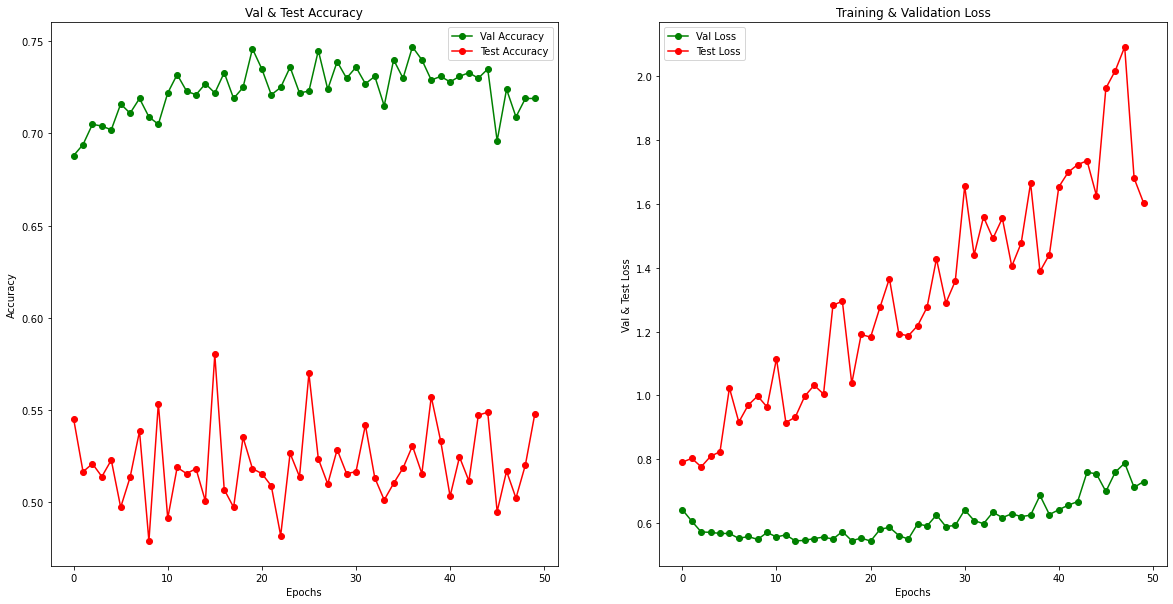

In [75]:
plot_accuracy_loss_chart_test(callbacks,50)